![image.png](https://towardsdatascience.com/wp-content/uploads/2024/05/1Qww2aaIdqrWVeNmo3AS0ZQ-2048x1314.png)




# BERT (encoder-only)

BERT is an "encoder-only" [transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) "Transformer (machine learning model)") architecture. At a high level, BERT consists of 4 modules:

-   Tokenizer: This module converts a piece of English text into a sequence of integers ("tokens").
-   [Embedding](https://en.wikipedia.org/wiki/Word_embedding "Word embedding"): This module converts the sequence of tokens into an array of real-valued vectors representing the tokens. It represents the conversion of discrete token types into a lower-dimensional [Euclidean space](https://en.wikipedia.org/wiki/Euclidean_space "Euclidean space").
-   Encoder: a stack of Transformer blocks with [self-attention](https://en.wikipedia.org/wiki/Attention_(machine_learning) "Attention (machine learning)"), but without causal masking.
-   Task head: This module converts the final representation vectors into one-hot encoded tokens again by producing a predicted probability distribution over the token types. It can be viewed as a simple decoder, decoding the latent representation into token types, or as an "un-embedding layer".

The task head is necessary for pre-training, but it is often unnecessary for so-called "downstream tasks," such as [question answering](https://en.wikipedia.org/wiki/Question_answering "Question answering") or [sentiment classification](https://en.wikipedia.org/wiki/Sentiment_analysis "Sentiment analysis"). Instead, one removes the task head and replaces it with a newly initialized module suited for the task, and finetune the new module. The latent vector representation of the model is directly fed into this new module, allowing for sample-efficient [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning "Transfer learning").

## Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Spectral Curvature

###### Load Model

In [ ]:
MODEL_NAME = "bert-large-uncased"

PROMPT1 = "The artist drew a landscape with a river flowing towards the mountains." # Plain English
PROMPT2 = "इसे आज़माने के लिए, नीचे अपनी भाषा और इनपुट उपकरण चुनें और लिखना आरंभ करें|" # Hindi
PROMPT3 = '''**The CS- Inequality**\$$\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n
a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)$$''' #Math Jargon
PROMPT4 = "श्वः अतीव द्रुतं धावति" #Sanskrit
PROMPT5 = '''Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}
\left[ \frac{1}{2} g^{\mu\nu}(x) \partial_\mu \phi(x) \, \partial_\nu \phi(x)
- \frac{1}{2} m^2 \phi^2(x)
- \frac{\lambda}{4!} \phi^4(x)
+ \frac{1}{16\pi G} (R(x) - 2\Lambda) \right] \right)''' #Math jargon 2


PROMPT = PROMPT5

print(f"Loading model: {MODEL_NAME}...") # Load the Tokenizer, Model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

model.eval() # Set the model to evaluation mode
print("Model loaded successfully.")

<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:5: SyntaxWarning: invalid escape sequence '\$'
<>:8: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2131410676.py:5: SyntaxWarning: invalid escape sequence '\$'
  PROMPT3 = "**The Cauchy-Schwarz Inequality**\$$\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)$$" #nput prompt3
/tmp/ipython-input-2131410676.py:8: SyntaxWarning: invalid escape sequence '\i'
  PROMPT6 = '''Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}


Loading model: bert-large-uncased...
Model loaded successfully.


In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [ ]:
model.encoder.layer

ModuleList(
  (0-23): 24 x BertLayer(
    (attention): BertAttention(
      (self): BertSdpaSelfAttention(
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=1024, out_features=4096, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=4096, out_features=1024, bias=True)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
  

###### Place Hooks

In [ ]:
# Capture Activations

captured_activations = [] # Store the output (hidden state) of each layer.

def get_activation_hook():
    """
    Returns a hook function that can be attached to a PyTorch module.
    The hook will append the module's output to our `captured_activations` list.
    """
    def hook(module, input, output):
        captured_activations.append(output[0].detach().cpu())
    return hook

# Get the list of transformer layers
target_layers = model.encoder.layer

# Register our hook on each layer
for layer in target_layers:
    layer.register_forward_hook(get_activation_hook())

print(f"Registered hooks on {len(target_layers)} layers.")

Registered hooks on 24 layers.


###### Calculate Spectral Curvature, $ ∀ $ layers $ l $ :

$$ K_l = || K_{l+1} - 2K_l + K_{l-1}||_{frobenius}$$





In [ ]:
# Forward Pass
inputs = tokenizer(PROMPT, return_tensors="pt")
print("Running forward pass to capture activations...")
with torch.no_grad():
    outputs = model(**inputs)

print(f"Successfully captured {len(captured_activations)} hidden states.")

Running forward pass to capture activations...
Successfully captured 24 hidden states.


In [ ]:
# check:
inspec = []
i = 10
h_prev = captured_activations[i-1]
h_curr = captured_activations[i]
h_next = captured_activations[i+1]

print("3 activations:", h_prev, h_curr, h_next)
print ("---------------------------------------------------------------------------------------------")

bending_vector = h_next - 2 * h_curr + h_prev
print(bending_vector)
print ("---------------------------------------------------------------------------------------------")

curvature = torch.linalg.norm(bending_vector).item()
inspec.append(curvature)
print(inspec)

3 activations: tensor([[[-0.1738, -0.0967, -1.0453,  ..., -0.3006, -0.3920,  0.5932],
         [-0.4908, -0.7233,  0.7674,  ..., -0.2477,  0.6125,  0.1601],
         [-1.4448,  0.7804,  0.6184,  ...,  1.1896,  1.1774, -0.2939],
         ...,
         [-1.0388, -0.3448,  1.4964,  ...,  0.6862,  0.1894,  0.6569],
         [-0.0019,  0.1290, -0.3617,  ...,  0.5059,  0.0545, -0.2054],
         [ 0.0217,  0.0345, -0.1259,  ..., -0.0214,  0.0652, -0.0146]]]) tensor([[[-0.2474, -0.1016, -1.5624,  ..., -0.2758, -0.8255,  0.6348],
         [-0.4881, -0.3301,  0.3491,  ...,  0.1391,  0.2589, -0.1933],
         [-1.6315,  0.7019,  0.8759,  ...,  0.9238,  1.0922, -0.7107],
         ...,
         [-1.6392, -0.1929,  0.8638,  ...,  0.6532,  0.1204,  0.2716],
         [ 0.0034,  0.0517, -1.0286,  ...,  0.7216,  0.0107, -0.7652],
         [ 0.0474, -0.0388, -0.1048,  ..., -0.0123, -0.0835,  0.0316]]]) tensor([[[-0.1253, -0.2554, -1.2662,  ..., -0.1123, -0.8046,  0.6351],
         [-0.7564,  0.0054,  0

In [ ]:
# Calculate the Spectral Curvature
spectral_curvatures = []
print("Calculating spectral curvature...")
for i in range(1, len(captured_activations) - 1):
    h_prev = captured_activations[i-1]
    h_curr = captured_activations[i]
    h_next = captured_activations[i+1]

    bending_vector = h_next - 2 * h_curr + h_prev

    # Calculate its magnitude using the Frobenius norm to get a single scalar value.
    curvature = torch.linalg.norm(bending_vector).item()
    spectral_curvatures.append(curvature)

# Print the raw curvature values for inspection
for i, curve in enumerate(spectral_curvatures):
    # The layer number is i+1 because our loop starts its calculation at the 2nd layer.
    print(f"  - Curvature at Layer {i + 1}: {curve:.4f}")

Calculating spectral curvature...
  - Curvature at Layer 1: 138.4928
  - Curvature at Layer 2: 121.9096
  - Curvature at Layer 3: 108.8429
  - Curvature at Layer 4: 123.1918
  - Curvature at Layer 5: 153.9402
  - Curvature at Layer 6: 181.6430
  - Curvature at Layer 7: 161.3245
  - Curvature at Layer 8: 163.4683
  - Curvature at Layer 9: 160.7339
  - Curvature at Layer 10: 176.5997
  - Curvature at Layer 11: 168.8460
  - Curvature at Layer 12: 162.5035
  - Curvature at Layer 13: 170.4438
  - Curvature at Layer 14: 191.1957
  - Curvature at Layer 15: 157.4857
  - Curvature at Layer 16: 145.7744
  - Curvature at Layer 17: 137.9570
  - Curvature at Layer 18: 131.8754
  - Curvature at Layer 19: 164.8761
  - Curvature at Layer 20: 153.4233
  - Curvature at Layer 21: 129.0575
  - Curvature at Layer 22: 256.1677


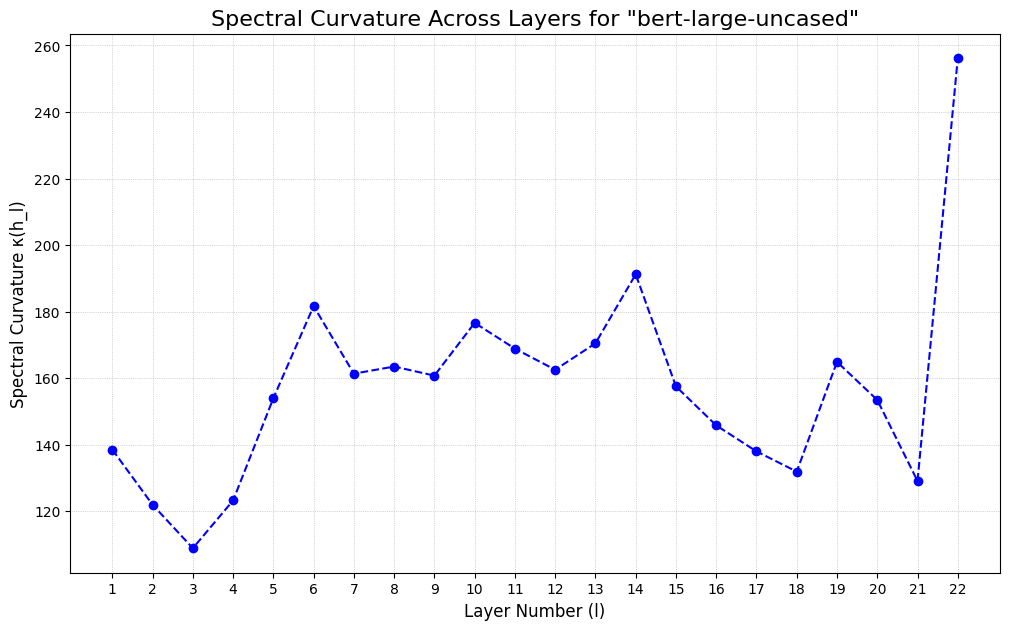

In [ ]:
layer_indices = range(1, len(spectral_curvatures) + 1)

plt.figure(figsize=(12, 7))
plt.plot(layer_indices, spectral_curvatures, marker='o', linestyle='--', color='b')
plt.title(f'Spectral Curvature Across Layers for "{MODEL_NAME}"', fontsize=16)
plt.xlabel('Layer Number (l)', fontsize=12)
plt.ylabel('Spectral Curvature κ(h_l)', fontsize=12)
plt.xticks(list(layer_indices))
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.show()

## Thermodynamic Length

In [ ]:
# Config
MODEL_NAME   = "bert-large-uncased"
MAX_SAMPLES  = 500          # number of text rows from the dataset to use
BATCH_SIZE   = 2            # Further reduce batch size to conserve memory
MAX_SEQ_LEN  = 64           # Further reduce sequence length to conserve memory
MASK_PROB    = 0.15
NUM_WORKERS  = 2
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Repro (optional)
SEED = 4200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# GPU knobs
if DEVICE == "cuda":
    # TF32 for speed on Ampere/Hopper
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x

    # Fast SDPA kernels
    try:
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        torch.backends.cuda.enable_math_sdp(True)
    except Exception:
        pass  # older PyTorch

In [ ]:
# Load model & tokenizer
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

# Freeze head params
for p in model.cls.parameters():
    p.requires_grad_(False)

# For Convenience
encoder_layers = model.bert.encoder.layer
num_layers     = len(encoder_layers)
print(f"Model has {num_layers} encoder layers")

Loading model: bert-large-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model has 24 encoder layers


In [ ]:
# Dataset
# ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train") #Load wikitext-2-raw-v1 (train split)
ds = load_dataset("ag_news", split="train")
# The first few examples from the dataset
print("First few examples from the dataset:")
for i in range(10):
    print(f"\n--- Example {i+1} ---")
    print(ds[i]['text'])

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

First few examples from the dataset:

--- Example 1 ---
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

--- Example 2 ---
Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

--- Example 3 ---
Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

--- Example 4 ---
Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official sai

In [ ]:
# Filter to non-trivial rows and take the first MAX_SAMPLES
ds = ds.filter(lambda ex: len(ex["text"].strip()) > 100)
if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))
print(f"Dataset size after filtering: {len(ds)} rows")
# The first few examples from the refined dataset
print("First few examples from the dataset:")
for i in range(10):
    print(f"\n--- Example {i+1} ---")
    print(ds[i]['text'])

Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Dataset size after filtering: 500 rows
First few examples from the dataset:

--- Example 1 ---
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

--- Example 2 ---
Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

--- Example 3 ---
Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

--- Example 4 ---
Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could str

In [ ]:
# Collate: tokenize + mask 15%

mask_token_id = tokenizer.mask_token_id
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

      '''This `mlm_collate(batch)` (below) function's job is to:

      1.  Tokenize: Convert the raw text into numerical IDs.
      2.  Pad: Make all sequences in the batch the same length by adding padding tokens.
      3.  Create Labels: Set up the ground-truth answers for the model to learn from.
      4.  Format: Assemble everything into a neat dictionary of tensors.

      '''

def mlm_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=MAX_SEQ_LEN, #MAX_SEQ_LEN  = 64
        return_tensors="pt",
        return_special_tokens_mask=True,
                   )

    input_ids = tok["input_ids"]
    attention_mask = tok["attention_mask"]
    special_mask = tok["special_tokens_mask"].bool()

    # Candidates for masking: attention==1 and not special tokens
    candidate = attention_mask.bool() & (~special_mask)

    # Sample masks
    rand = torch.rand_like(input_ids, dtype=torch.float)
    mask = (rand < MASK_PROB) & candidate #MASK_PROB    = 0.15

    # Guarantees that every sentence in the batch contributes to the loss calculation.
    for i in range(mask.size(0)):
        if not mask[i].any():
            cand_idx = candidate[i].nonzero(as_tuple=False).view(-1)
            if cand_idx.numel() > 0:
                j = cand_idx[torch.randint(0, cand_idx.numel(), (1,))].item()
                mask[i, j] = True

    labels = input_ids.clone()
    labels[~mask] = -100  # only masked positions contribute to CE

    # Replace masked tokens with [MASK]
    input_ids = input_ids.masked_fill(mask, mask_token_id)

    batch = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": tok.get("token_type_ids", torch.zeros_like(input_ids)),
        "labels": labels,
        "num_masked": mask.sum(dim=1),  # per-example masked count (diagnostics)
    }
    return batch

In [ ]:
loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=mlm_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [ ]:
# Main computation

layer_grad_sums = torch.zeros(num_layers, device=DEVICE)  # accumulate per-layer ||grad||^2
num_batches = 0

print("Starting per-layer effort computation (Observed Fisher style) ...")

# AMP autocast
amp_dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16

for batch in loader:
    num_batches += 1

    # Move to device
    input_ids      = batch["input_ids"].to(DEVICE, non_blocking=True)
    attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
    token_type_ids = batch["token_type_ids"].to(DEVICE, non_blocking=True)
    labels         = batch["labels"].to(DEVICE, non_blocking=True)

    # Build extended attention mask once per batch of Shape: (B, 1, 1, S)
    extended_mask = model.get_extended_attention_mask(attention_mask, attention_mask.shape, DEVICE)

    # Initial hidden states
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
        h = model.bert.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

    # Collect per-layer losses
    per_layer_losses = []

    # Forward across layers, isolating each layer's graph:
    for ell in range(num_layers):
        # Detach BEFORE the layer to prevent grads from flowing to earlier blocks
        h_prev = h.detach()

        # Run only this layer (keep computation in AMP)
        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda")):
            h_ell = encoder_layers[ell](h_prev, attention_mask=extended_mask)[0]
            logits = model.cls(h_ell)  # readout at this layer (logit lens)

            # Cross-entropy ONLY on masked positions (ignore_index=-100)
            # Use mean reduction to stabilize scale across different #masked
            loss_ell = F.cross_entropy(
                logits.view(-1, model.config.vocab_size),
                labels.view(-1),
                ignore_index=-100,
                reduction="mean",
            )
        per_layer_losses.append(loss_ell)
        h = h_ell  # advance hidden state for next layer

    # Single backward for all layers’ losses (speeds things up a lot)
    model.zero_grad(set_to_none=True)
    total_loss = torch.stack(per_layer_losses).sum()
    total_loss.backward()

    # Accumulate squared grad norms for each layer's parameters (GPU-side)
    with torch.no_grad():
        for ell in range(num_layers):
            grad_sq = torch.tensor(0.0, device=DEVICE)
            for p in encoder_layers[ell].parameters():
                if p.grad is not None:
                    grad_sq = grad_sq + (p.grad.detach() ** 2).sum()
            layer_grad_sums[ell] += grad_sq

# Move to CPU for display
layer_grad_sums_cpu = layer_grad_sums.detach().cpu().numpy()
mean_layer_grad_sq = layer_grad_sums_cpu / max(1, num_batches)  # mean over batches

Starting per-layer effort computation (Observed Fisher style) ...


In [ ]:
# Report
print("\n--- Per-layer squared gradient norms (mean over batches) ---")
for i, val in enumerate(mean_layer_grad_sq, start=1):
    print(f"Layer {i:2d}: {val: .6e}")


--- Per-layer squared gradient norms (mean over batches) ---
Layer  1:  2.311032e+02
Layer  2:  6.037651e+02
Layer  3:  5.781060e+02
Layer  4:  8.539621e+02
Layer  5:  6.578585e+02
Layer  6:  6.359260e+02
Layer  7:  9.803958e+02
Layer  8:  1.253693e+03
Layer  9:  9.913492e+02
Layer 10:  1.041660e+03
Layer 11:  8.179916e+02
Layer 12:  5.836429e+02
Layer 13:  4.937080e+02
Layer 14:  4.341765e+02
Layer 15:  3.222491e+02
Layer 16:  3.002657e+02
Layer 17:  3.160039e+02
Layer 18:  3.167825e+02
Layer 19:  2.835372e+02
Layer 20:  2.160113e+02
Layer 21:  2.249707e+02
Layer 22:  1.839733e+02
Layer 23:  1.597571e+02
Layer 24:  1.333795e+02


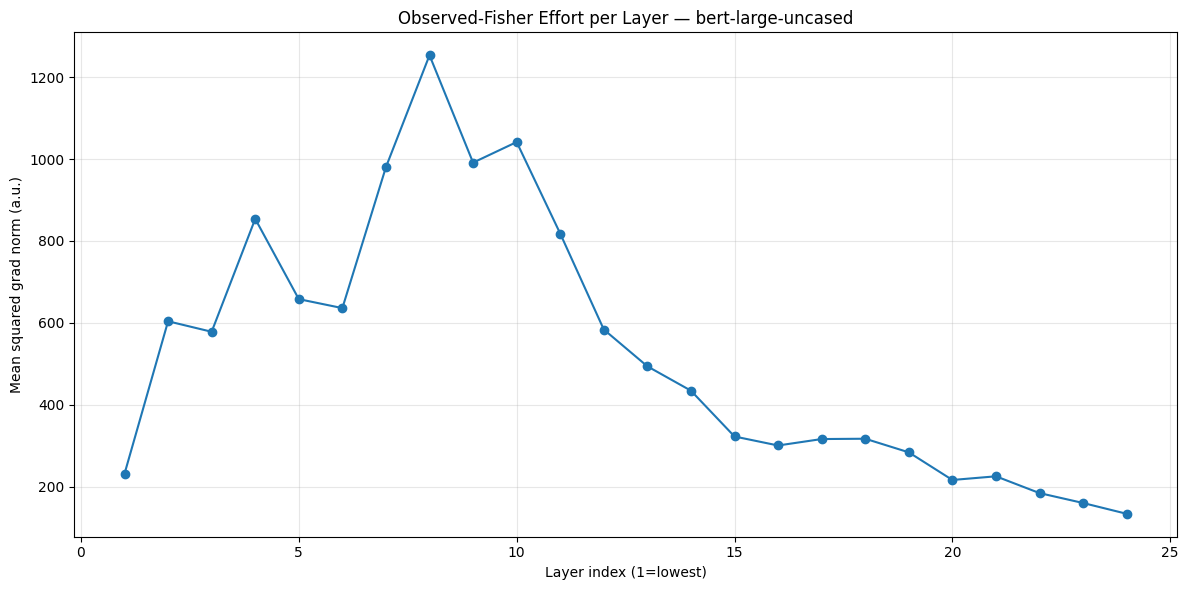

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(1, num_layers+1), mean_layer_grad_sq, marker='o')
plt.title(f'Observed-Fisher Effort per Layer — {MODEL_NAME}')
plt.xlabel('Layer index (1=lowest)')
plt.ylabel('Mean squared grad norm (a.u.)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Belief Factors


Using device: cuda
Loading model: bert-large-uncased


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if

Model has 24 encoder layers, hidden size 1024, vocab size 30522
Loading wikitext-2-raw-v1 (train) as a stand-in for P^(c)...
Dataset size after filtering: 400 rows
Computing Belief Vector Field in MODE='observed' ...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1773: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



--- Belief Vector Field: per-layer magnitudes (L2 norms) ---
Layer  1:  1.143189e-01
Layer  2:  1.037843e-01
Layer  3:  9.841974e-02
Layer  4:  1.126629e-01
Layer  5:  1.443671e-01
Layer  6:  1.681534e-01
Layer  7:  2.334747e-01
Layer  8:  2.022397e-01
Layer  9:  1.462584e-01
Layer 10:  1.372768e-01
Layer 11:  9.321694e-02
Layer 12:  6.905106e-02
Layer 13:  4.635986e-02
Layer 14:  2.596614e-02
Layer 15:  2.026491e-02
Layer 16:  1.671201e-02
Layer 17:  1.537907e-02
Layer 18:  1.386703e-02
Layer 19:  1.393465e-02
Layer 20:  1.328959e-02
Layer 21:  1.252195e-02
Layer 22:  1.179593e-02
Layer 23:  1.103217e-02
Layer 24:  8.511890e-03


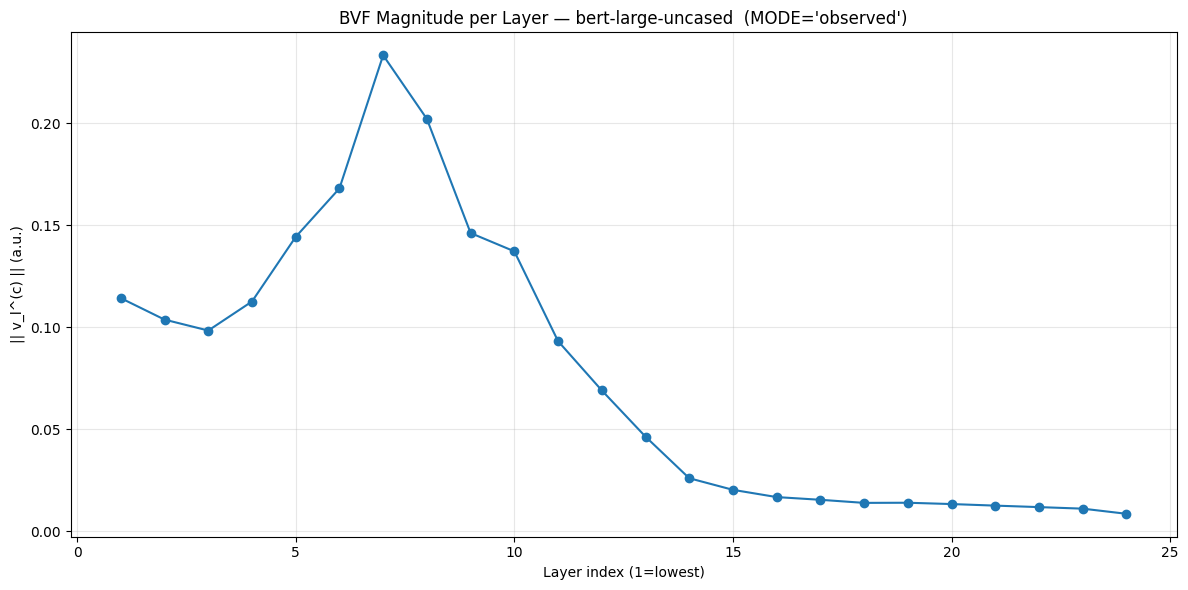


Done.


In [ ]:
# Belief Vector Field (BVF) per Layer for BERT-Large
# ---------------------------------------------------
# v_l^(c) = E_{(x,t) ~ P^(c)} [ ∇_{h_l} log Ψ_l(x,t) ]
# Two Ψ choices:
#   (A) Observed (label-based):      Ψ_l = p_l(y* | x,t)           # needs labels at masked positions
#   (B) Concept-mass (label-free):   Ψ_l = sum_{y in S^(c)} p_l(y)  # requires a concept vocab set S^(c)
#
# Implementation: for each layer l, we (i) read out logits from h_l with the MLM head ("logit lens"),
# (ii) build a scalar loss = - mean(log Ψ_l) over positions, (iii) backprop ONCE for all layers,
# and (iv) collect -∂loss/∂h_l = ∇_{h_l} log Ψ_l. We then average across masked positions/events.
# --------------------------
# Config
# --------------------------
MODEL_NAME    = "bert-large-uncased"
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Data / batching
MAX_SAMPLES   = 400            # number of rows from the corpus (increase for better estimates)
BATCH_SIZE    = 2              # Reduce batch size further
MAX_SEQ_LEN   = 64           # Reduce sequence length further
MASK_PROB     = 0.15           # BERT-style 15% masking of non-special tokens
NUM_WORKERS   = 2

# Belief scalar Ψ
MODE = "observed"              # "observed" or "concept"
# For MODE="concept", provide a concept lexicon in tokens (must be in BERT vocab).
CONCEPT_TOKENS = [
    # Example for a "protest" concept; REPLACE with your own concept lexicon
    "protest", "protests", "protester", "protesters",
    "strike", "strikes", "march", "marches",
    "rally", "rallies", "demonstration", "demonstrations"
]
# Whether to restrict evaluation to masked positions (recommended for MLM)
USE_MASKED_POSITIONS_ONLY = True

# Precision & speed
USE_COMPILE  = False           # torch.compile (PyTorch 2.x)
USE_BF16_AMP = True            # autocast to bfloat16 on CUDA if supported

print(f"Using device: {DEVICE}")

# --------------------------
# Repro (optional)
# --------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# --------------------------
# GPU knobs (speed)
# --------------------------
if DEVICE == "cuda":
    # TF32 for speed on Ampere/Hopper
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass
    # Fast SDPA kernels (PyTorch 2.x)
    try:
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        torch.backends.cuda.enable_math_sdp(True)
    except Exception:
        pass

# --------------------------
# Load model & tokenizer
# --------------------------
print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
model.eval().to(DEVICE)

if USE_COMPILE and hasattr(torch, "compile"):
    model = torch.compile(model, mode="max-autotune")

# Freeze ALL parameters to avoid computing/storing grads on weights
for p in model.parameters():
    p.requires_grad_(False)

# Convenience handles
encoder_layers = model.bert.encoder.layer
num_layers     = len(encoder_layers)
hidden_size    = model.config.hidden_size
vocab_size     = model.config.vocab_size
print(f"Model has {num_layers} encoder layers, hidden size {hidden_size}, vocab size {vocab_size}")

# --------------------------
# Dataset (your P^(c))
# --------------------------
# Here we instantiate P^(c) as the Wikitext-2 (train) slice; in practice, replace with your culture/context corpus.
print("Loading wikitext-2-raw-v1 (train) as a stand-in for P^(c)...")
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
# Filter to non-trivial rows and take the first MAX_SAMPLES
ds = ds.filter(lambda ex: len(ex["text"].strip()) > 100)
if MAX_SAMPLES is not None:
    ds = ds.select(range(min(MAX_SAMPLES, len(ds))))
print(f"Dataset size after filtering: {len(ds)} rows")

# --------------------------
# Collate: tokenize + 15% masking
# --------------------------
mask_token_id = tokenizer.mask_token_id
cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

def mlm_collate(batch):
    texts = [ex["text"] for ex in batch]
    tok = tokenizer(
        texts,
        padding="longest",            # dynamic padding per batch
        truncation=True,
        max_length=MAX_SEQ_LEN,
        return_tensors="pt",
        return_special_tokens_mask=True,
    )
    input_ids = tok["input_ids"]
    attention_mask = tok["attention_mask"]
    special_mask = tok["special_tokens_mask"].bool()

    # Candidates: non-special tokens that are attended
    candidate = attention_mask.bool() & (~special_mask)

    # 15% random masking over candidates
    rand = torch.rand_like(input_ids, dtype=torch.float)
    mask = (rand < MASK_PROB) & candidate

    # Ensure at least one mask per sequence if possible
    for i in range(mask.size(0)):
        if not mask[i].any():
            cand_idx = candidate[i].nonzero(as_tuple=False).view(-1)
            if cand_idx.numel() > 0:
                j = cand_idx[torch.randint(0, cand_idx.numel(), (1,))].item()
                mask[i, j] = True

    # Labels are original tokens at masked positions; -100 elsewhere
    labels = input_ids.clone()
    labels[~mask] = -100

    # Replace masked tokens with [MASK]
    input_ids = input_ids.masked_fill(mask, mask_token_id)

    batch = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": tok.get("token_type_ids", torch.zeros_like(input_ids)),
        "labels": labels,
        "masked_bool": mask,     # for position selection (even in MODE="concept")
    }
    return batch

loader = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=mlm_collate,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# --------------------------
# Concept lexicon -> vocab ids (for MODE="concept")
# --------------------------
if MODE == "concept":
    # NOTE: BERT uses WordPiece. We keep only tokens that are present as single vocab entries.
    # If a word is split (e.g., "demonstration" -> "demon", "##stration"), you can either:
    #  (i) include its subword(s) explicitly, or (ii) choose a synonym that is a single token.
    concept_ids = []
    for tok in CONCEPT_TOKENS:
        tid = tokenizer.convert_tokens_to_ids(tok)
        if tid is not None and tid != tokenizer.unk_token_id:
            concept_ids.append(tid)
    concept_ids = sorted(set(concept_ids))
    if len(concept_ids) == 0:
        raise ValueError("Your CONCEPT_TOKENS did not map to any single-token ids. "
                         "Provide tokens that exist in the WordPiece vocab (including '##' forms if needed).")
    concept_ids_tensor = torch.tensor(concept_ids, device=DEVICE)
    print(f"[Concept mode] Using {len(concept_ids)} vocab ids for the concept.")

# --------------------------
# Main computation
# --------------------------
# We will accumulate a vector per layer: sum of gradients over events, then divide by total events.
bvf_sum_per_layer = torch.zeros(num_layers, hidden_size, device=DEVICE)  # Σ ∇_{h_l} log Ψ
count_events = 0  # number of positions contributing (masked positions if USE_MASKED_POSITIONS_ONLY)

print(f"Computing Belief Vector Field in MODE='{MODE}' ...")
amp_dtype = torch.bfloat16 if (DEVICE=="cuda" and USE_BF16_AMP and torch.cuda.is_bf16_supported()) else torch.float32

for batch in loader:
    # H2D (async)
    input_ids      = batch["input_ids"].to(DEVICE, non_blocking=True)
    attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
    token_type_ids = batch["token_type_ids"].to(DEVICE, non_blocking=True)
    labels         = batch["labels"].to(DEVICE, non_blocking=True)
    masked_bool    = batch["masked_bool"].to(DEVICE, non_blocking=True)

    # Which positions contribute as "events"
    if USE_MASKED_POSITIONS_ONLY:
        pos_mask = masked_bool
    else:
        pos_mask = attention_mask.bool()  # all attended positions
    # Batch event count (avoid zero division)
    batch_events = pos_mask.sum().item()
    if batch_events == 0:
        continue

    # Extended attention mask once per batch
    extended_mask = model.get_extended_attention_mask(attention_mask, attention_mask.shape, DEVICE)

    # Initial hidden states (embeddings)
    with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda" and USE_BF16_AMP)):
        h = model.bert.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

    # We'll keep references to each h_l to read .grad after a single backward
    h_refs = []
    losses = []

    # Forward across layers; isolate each block by detaching BEFORE it,
    # and ensure the block's input requires grad so that h_l requires grad.
    for ell in range(num_layers):
        h_prev = h.detach()               # cut graph to earlier blocks
        h_prev.requires_grad_(True)       # ensure grad tracking from this point on

        with torch.autocast(device_type="cuda", dtype=amp_dtype, enabled=(DEVICE=="cuda" and USE_BF16_AMP)):
            h_l = encoder_layers[ell](h_prev, attention_mask=extended_mask)[0]
            h_l.retain_grad()             # we want ∂loss/∂h_l

            logits = model.cls(h_l)       # readout at layer ell (logit lens)

            if MODE == "observed":
                # Mean CE only at masked positions => mean(-log p_l(y*))
                loss_ell = F.cross_entropy(
                    logits.view(-1, vocab_size),
                    labels.view(-1),
                    ignore_index=-100,
                    reduction="mean",
                )
            else:  # MODE == "concept"
                # log Ψ = log P_c = logsumexp over concept ids of log-softmax(logits)
                log_probs = F.log_softmax(logits, dim=-1)  # [B, S, V]
                # Gather concept token log-probs and logsumexp across concept dimension
                # Shape: [B, S, |S_c|] -> [B, S]
                log_pc = torch.logsumexp(log_probs.index_select(-1, concept_ids_tensor), dim=-1)
                # Mean over chosen positions
                # (mask out positions not in pos_mask)
                # Add a tiny epsilon guard if ever needed; logsumexp is stable already.
                loss_ell = -(log_pc[pos_mask].mean())

        h = h_l
        h_refs.append(h_l)
        losses.append(loss_ell)

    # Single backward for all layers (lower overhead than 24 separate backprops)
    total_loss = torch.stack(losses).sum()
    model.zero_grad(set_to_none=True)
    total_loss.backward()

    # Accumulate BVF vector per layer:
    # v_l = E[ ∇_{h_l} log Ψ ] = - E[ ∂loss_l/∂h_l ]  because loss_l = - mean(log Ψ)
    with torch.no_grad():
        # count events in this batch
        nevents = pos_mask.sum().item()
        if nevents > 0:
            for ell in range(num_layers):
                grad_hl = h_refs[ell].grad  # shape [B, S, H]
                # Signed gradient of log Ψ:
                v_batch = (-grad_hl)[pos_mask]  # shape [N_events, H]
                # Sum over events in batch
                bvf_sum_per_layer[ell] += v_batch.sum(dim=0)
            count_events += nevents

# Final BVF = sum / count  (mean over events)
bvf_per_layer = (bvf_sum_per_layer / max(1, count_events)).detach().cpu().numpy()
bvf_norms = np.linalg.norm(bvf_per_layer, axis=1)

# --------------------------
# Report
# --------------------------
print("\n--- Belief Vector Field: per-layer magnitudes (L2 norms) ---")
for i, val in enumerate(bvf_norms, start=1):
    print(f"Layer {i:2d}: {val: .6e}")

# Optional: quick plot of magnitudes
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,6))
    plt.plot(range(1, num_layers+1), bvf_norms, marker='o')
    plt.title(f"BVF Magnitude per Layer — {MODEL_NAME}  (MODE='{MODE}')")
    plt.xlabel("Layer index (1=lowest)")
    plt.ylabel("|| v_l^(c) || (a.u.)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception:
    pass

print("\nDone.")